In [12]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd

In [13]:
COSMOS_filename = os.path.join(dwarfz.data_dir_default, "COSMOS_reference.sqlite")
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [14]:
HSC_filename = os.path.join(dwarfz.data_dir_default, "HSC_COSMOS_median_forced.sqlite3")
HSC = dwarfz.datasets.HSC(HSC_filename)

In [15]:
matches_filename = os.path.join(dwarfz.data_dir_default, "matches.sqlite3")
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [16]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags", "gcmodel_mag",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags", "rcmodel_mag",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags", "icmodel_mag",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags", "zcmodel_mag",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags", "ycmodel_mag",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values

## Turn magnitudes into colors

In [17]:
combined["g_minus_r"] = combined.gcmodel_mag - combined.rcmodel_mag
combined["r_minus_i"] = combined.rcmodel_mag - combined.icmodel_mag
combined["i_minus_z"] = combined.icmodel_mag - combined.zcmodel_mag
combined["z_minus_y"] = combined.zcmodel_mag - combined.ycmodel_mag

## Filter out bad data

In [28]:
mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_mag"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

# Create Classification Labels

In [ ]:
low_z    = (combined.photo_z  < .15)
low_mass = (combined.log_mass > 8) & (combined.log_mass < 9)

In [ ]:
combined["low_z_low_mass"] = (low_z & low_mass)
combined.low_z_low_mass.mean()

# Magnitude Distributions

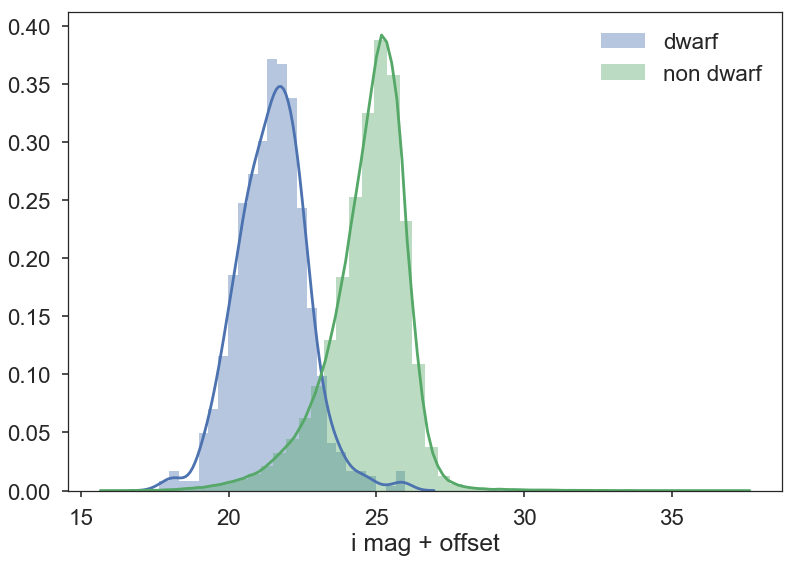

In [31]:
# sns.distplot(combined.log_icmodel_flux)
sns.distplot(combined.icmodel_mag[combined.low_z_low_mass], label="dwarf")
sns.distplot(combined.icmodel_mag[~combined.low_z_low_mass], label="non dwarf")

plt.legend(loc="best")
plt.xlabel("i mag + offset")


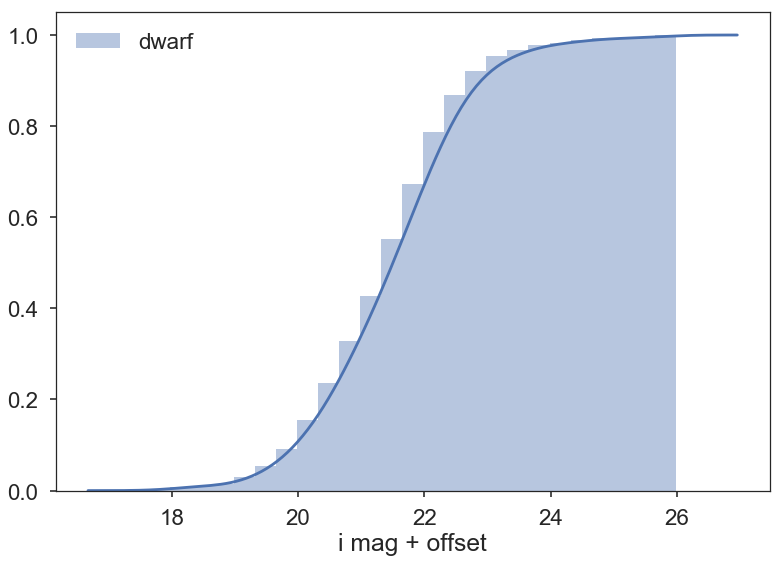

In [53]:
# sns.distplot(combined.log_icmodel_flux)
sns.distplot(combined.icmodel_mag[combined.low_z_low_mass], label="dwarf",
             hist_kws=dict(cumulative=True,),
             kde_kws=dict(cumulative=True),
            )

plt.legend(loc="best")
plt.xlabel("i mag + offset")


# Magnitude Limit of Dwarf Population

In [35]:
mags = np.linspace(17, 27, num=20)

dwarf = np.empty_like(mags)
non_dwarf = np.empty_like(mags)

for i in range(mags.size-1):
    mag_lim_low  = mags[i]
    mag_lim_high = mags[i+1]
    
    mask = (combined.icmodel_mag >= mag_lim_low) & (combined.icmodel_mag < mag_lim_high)
    
    dwarf[i] = combined[mask].low_z_low_mass.sum()
    non_dwarf[i] = (~combined[mask].low_z_low_mass).sum()


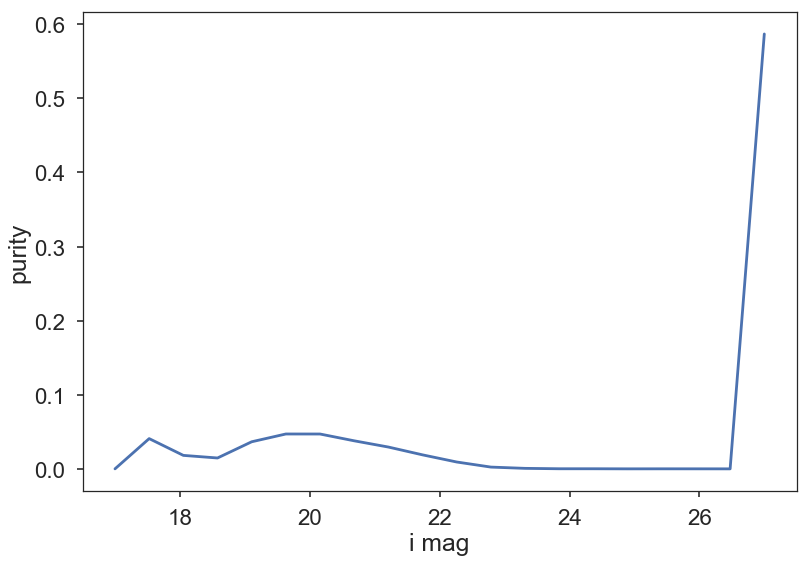

In [37]:
plt.plot(mags, dwarf / (dwarf + non_dwarf))

plt.ylabel("purity")
plt.xlabel("i mag")

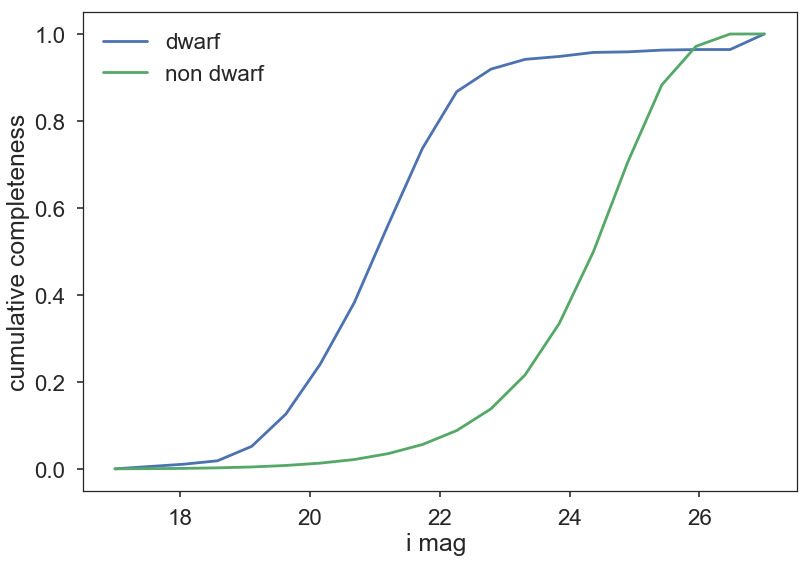

In [40]:
plt.plot(mags, dwarf.cumsum() / dwarf.sum(), label="dwarf")
plt.plot(mags, non_dwarf.cumsum() / non_dwarf.sum(), label="non dwarf")

plt.ylabel("cumulative completeness")
plt.xlabel("i mag ")

plt.legend(loc="best")

# Magnitude Limit Evolution with Redshift

In [41]:
mass_mask = (combined.log_mass > 8) & (combined.log_mass < 9)

In [60]:
zs = np.linspace(0, .5, num=40)
mag_limit = np.empty_like(zs)
for i in range(zs.size-1):
    z_low  = zs[i]
    z_high = zs[i+1]
    
    mask = mass_mask &  (combined.photo_z < z_high)
    
    mags = combined.icmodel_mag[mask]
    mag_limit[i] = np.percentile(mags, 80)

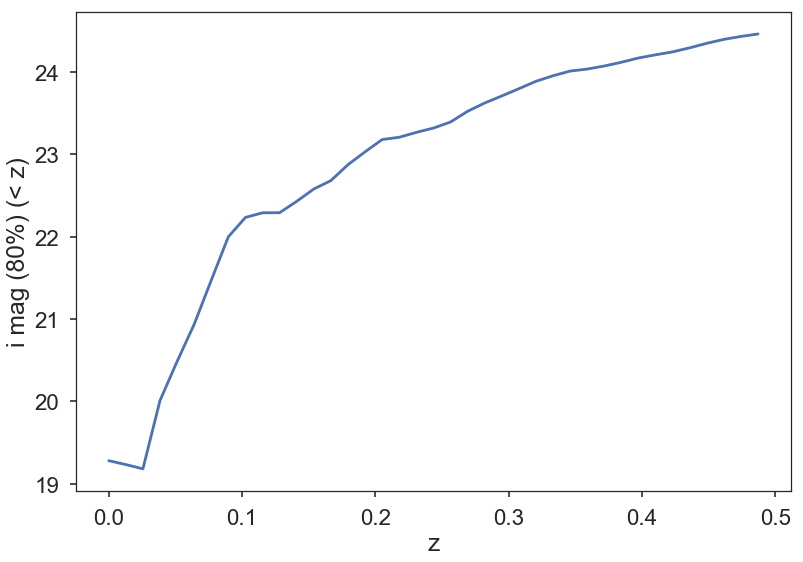

In [63]:
plt.plot(zs[:-1], mag_limit[:-1])
plt.xlabel("z")
plt.ylabel("i mag (80%) (< z)")

In [62]:
objects_below_limit = (combined.icmodel_mag < 22.5).sum()
objects_total = (combined.icmodel_mag < 22.5).size

objects_total / objects_below_limit

14.358983211773337

# Discussion

So if we hard-code a $i<22.5$ magnitude limit, that gets us an 80% completeness, but it only reduces our sample size by ~14x. Random Forest on the other hand can get us ~25x reduction for the same completeness